<a href="https://colab.research.google.com/github/arizonaCameraLab/computationalImaging/blob/master/Chapter2ForwardModels/neuralRepresentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Representation
## David Brady
## University of Arizona
## September 2023

### libraries

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras.models import Model
from tensorflow.keras.activations import gelu, elu, sigmoid, swish, relu
from tensorflow.keras.backend import get_value
import matplotlib.pyplot as plt
#from google.colab import files
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from scipy.special import j0
import cv2
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['font.size']= 22

2024-09-13 13:52:43.193947: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-13 13:52:43.335079: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Activation functions and peceptrons

  A perceptron operates on a data array $\bf f$ according to $g=o({\bf w}\cdot{\bf f}+b)$, where $o(\cdot )$ is the activation function, ${\bf w}$ is a weight vector and $b$ is a bias value. In typical neural models, the activation function acts as threshold returning positive values above the threshold and zero below threshold. But activation functions may alternatively serve to return frequency or local responses as illustrated by the $\sin(x)$ and Bessel $j0(x)$ functions shown below.

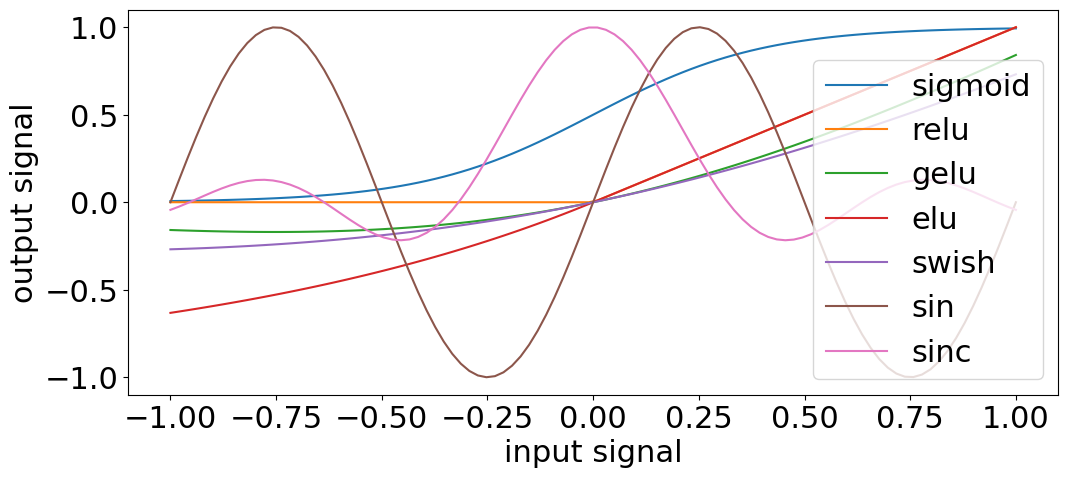

In [46]:
#
# relu, sigmoid and softmax optimization functions
#
x=np.linspace(-1,1,100)
plt.figure(figsize=(12,5))
plt.plot(x,sigmoid(5*x),label='sigmoid')
plt.plot(x,relu(x),label='relu')
plt.plot(x,gelu(x),label='gelu')
plt.plot(x,elu(x),label='elu')
plt.plot(x,swish(x),label='swish')
plt.plot(x,np.sin(2*np.pi*x),label='sin')
plt.plot(x,np.sinc(np.pi*x),label='sinc')
plt.xlabel('input signal')
plt.ylabel('output signal')
plt.legend()
plt.savefig('activation.pdf')
#files.download('activation.pdf')

For ${\bf f}\in \mathbb{R}^2$, the  perceptron separates the 2D plane with a line. Here we suppose for example that
 $${\bf w}=\begin{bmatrix}0.5\\0.25\end{bmatrix}$$
 and $b=0.2$

In [2]:
def grelu(x,y, w, b):
    gv=get_value(relu([w[0]*x+w[1]*y+b]))
    return gv
def ggelu(x,y, w, b):
    gv=get_value(gelu([w[0]*x+w[1]*y+b]))
    return gv
def gsigmoid(x,y, w, b):
    gv=get_value(sigmoid([w[0]*x+w[1]*y+b]))
    return gv
def gsin(x,y, w, b):
    gv=np.sin(2*np.pi*(w[0]*x+w[1]*y+b))
    return gv
def gj0(x,y, w, b):
    gv=j0(2*np.pi*(w[0]*x+w[1]*y+b))
    return gv
def gSinc(x,y, w, b):
    gv=tf.experimental.numpy.sinc(np.pi*(w[0]*x+w[1]*y+b))
    return gv


2024-09-13 13:52:54.274001: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-13 13:52:54.386304: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-13 13:52:54.386458: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-13 13:52:54.387716: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the

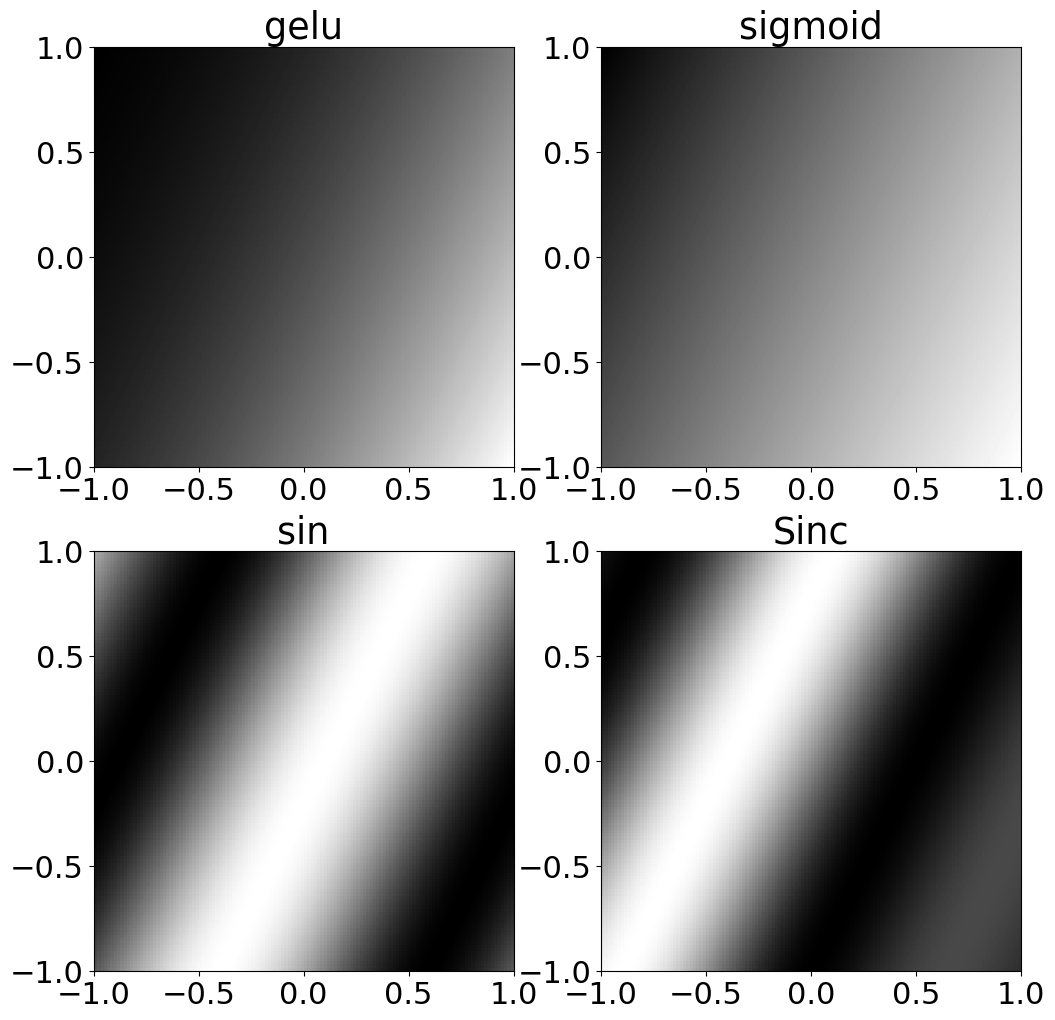

In [3]:
xRange=np.linspace(-1,1,128)
x,y=np.meshgrid(xRange,xRange)
w=[0.5,0.25]
b=0.2
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
pop=ggelu(x,y,w,b)[0,:,:]
plt.imshow(pop, extent=[-1,1,-1,1], cmap='gray')
plt.title('gelu')
plt.subplot(2,2,2)
pop=gsigmoid(x,y,w,b)[0,:,:]
plt.imshow(pop, extent=[-1,1,-1,1], cmap='gray')
plt.title('sigmoid')
plt.subplot(2,2,3)
pop=gsin(x,y,w,b)[:,:]
plt.imshow(pop, extent=[-1,1,-1,1], cmap='gray')
plt.title('sin')
plt.subplot(2,2,4)
pop=gSinc(x,y,w,b)[:,:]
plt.imshow(pop, extent=[-1,1,-1,1], cmap='gray')
plt.title('Sinc')
plt.savefig('2nodeSegmentation.pdf')

## Multilayer Perceptrons

A multilayer perceptron is a feedforward neural network  with an input layer, hidden layers and an output layer. MLP can be trained to implement arbitrary mappings between the input and output layers.

In [4]:
coords=tf.stack((x,y))
coords=tf.reshape(coords,[2,-1])
coords=tf.transpose(coords)

In [5]:
inputs=layers.Input(shape=( 2,))
initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.5, seed=15)
x1S=layers.Dense(256, activation=tf.math.sin,kernel_initializer=initializer, trainable=False)(inputs)
x2S=layers.Dense(16, activation=tf.math.sin,kernel_initializer=initializer, trainable=False)(x1S)
x3S=layers.Dense(8, activation=tf.math.sin,kernel_initializer=initializer, trainable=False)(x2S)
x4S=layers.Dense(1, activation=tf.math.sin,kernel_initializer=initializer,trainable=False)(x3S)
mlpSin=Model(inputs,x4S)
x1G=layers.Dense(256, activation='gelu',kernel_initializer=initializer, trainable=False)(inputs)
x2G=layers.Dense(16, activation='gelu',kernel_initializer=initializer, trainable=False)(x1G)
x3G=layers.Dense(8, activation='gelu',kernel_initializer=initializer,trainable=False)(x2G)
x4G=layers.Dense(1, activation='gelu',kernel_initializer=initializer,trainable=False)(x3G)
mlpG=Model(inputs,x4G)
x1J=layers.Dense(256, activation=tf.experimental.numpy.sinc,kernel_initializer=initializer, trainable=False)(inputs)
x2J=layers.Dense(16, activation=tf.experimental.numpy.sinc,kernel_initializer=initializer, trainable=False)(x1J)
x3J=layers.Dense(8, activation=tf.experimental.numpy.sinc,kernel_initializer=initializer,trainable=False)(x2J)
x4J=layers.Dense(1, activation=tf.experimental.numpy.sinc,kernel_initializer=initializer,trainable=False)(x3J)
mlpJ=Model(inputs,x4J)


In [51]:
mlpSimage=mlpSin.predict(coords)
mlpGimage=mlpG.predict(coords)
mlpJimage=mlpJ.predict(coords)

512/512 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
512/512 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
512/512 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


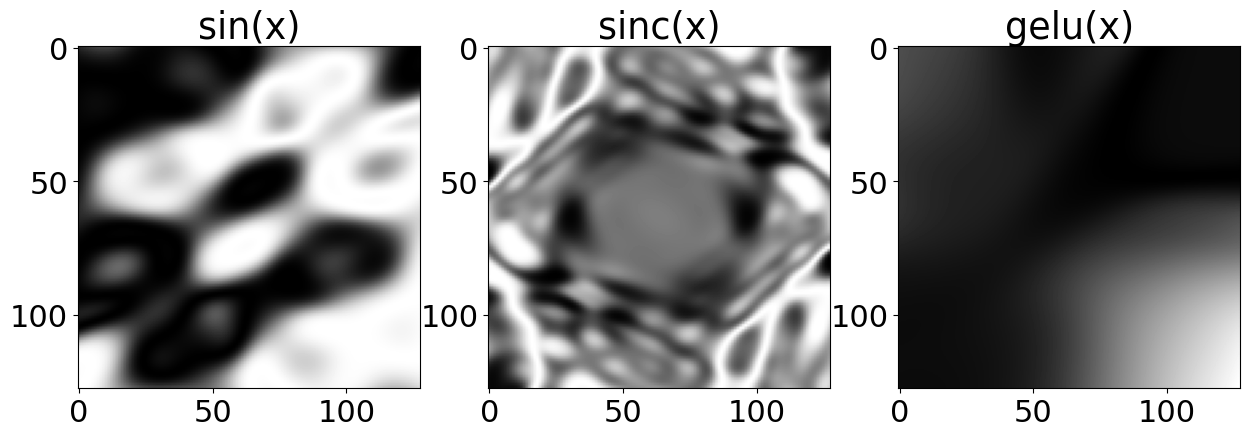

In [52]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(np.resize(mlpSimage,(128,128)),cmap='gray')
plt.title('sin(x)')
plt.subplot(1,3,2)
plt.imshow(np.resize(mlpJimage,(128,128)), cmap='gray')
plt.title('sinc(x)')
plt.subplot(1,3,3)
plt.imshow(np.resize(mlpGimage,(128,128)), cmap='gray')
plt.title('gelu(x)')
plt.savefig('mlpRandom.pdf')

## Learned neural representation

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()



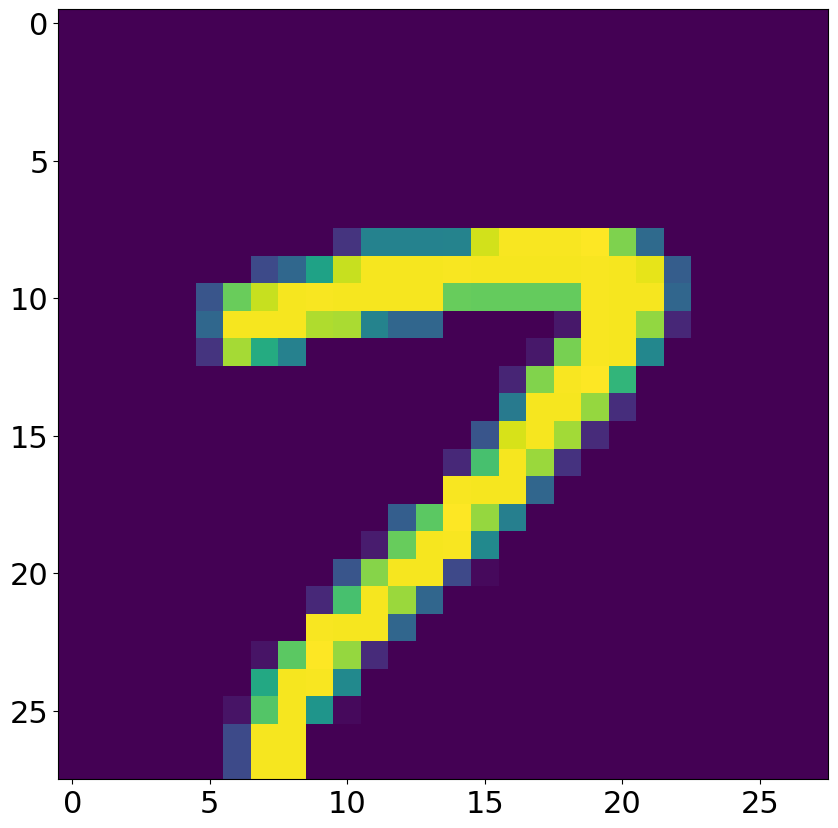

In [7]:
plt.imshow(x_train[123])


In [8]:
def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [np.linspace(-1, 1, sidelen)])
    mgrid = np.stack(np.meshgrid(*tensors), -1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

pixels=x_train[123,:,:]/255.
coords = get_mgrid(pixels.shape[0], 2)
pixels=pixels.reshape(28*28,1)
coords= coords.reshape(28*28,2)

train_dataset = tf.data.Dataset.from_tensor_slices(( coords, pixels))
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
upCoords=get_mgrid(256, 2)

## Siren

In [9]:

inputs=layers.Input(shape=( 2,))

 # Define the multilayer perceptron
x1=layers.Dense(16, activation=tf.math.sin)(inputs)
x2=layers.Dense(4, activation=tf.math.sin)(x1)
x=layers.Dense(1, activation='sigmoid')(x2)

mlp=Model(inputs, x)

 # Compile the model
mlp.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

mlp.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_12 (Dense)            (None, 16)                48        
                                                                 
 dense_13 (Dense)            (None, 4)                 68        
                                                                 
 dense_14 (Dense)            (None, 1)                 5         
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


In [10]:
mlp.fit(train_dataset, epochs=1000)


Epoch 1/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.2308 - accuracy: 0.4464
Epoch 2/1000
25/25 [==============================] - 0s 836us/step - loss: 0.1838 - accuracy: 0.6696
Epoch 3/1000
25/25 [==============================] - 0s 761us/step - loss: 0.1515 - accuracy: 0.8214
Epoch 4/1000
25/25 [==============================] - 0s 827us/step - loss: 0.1287 - accuracy: 0.8240
Epoch 5/1000
25/25 [==============================] - 0s 707us/step - loss: 0.1137 - accuracy: 0.8240
Epoch 6/1000
25/25 [==============================] - 0s 755us/step - loss: 0.1044 - accuracy: 0.8240
Epoch 7/1000
25/25 [==============================] - 0s 772us/step - loss: 0.0987 - accuracy: 0.8240
Epoch 8/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.0375 - accuracy: 1.0000

2024-09-13 13:53:24.674347: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


25/25 [==============================] - 0s 817us/step - loss: 0.0954 - accuracy: 0.8240
Epoch 9/1000
25/25 [==============================] - 0s 794us/step - loss: 0.0934 - accuracy: 0.8240
Epoch 10/1000
25/25 [==============================] - 0s 958us/step - loss: 0.0922 - accuracy: 0.8240
Epoch 11/1000
25/25 [==============================] - 0s 917us/step - loss: 0.0915 - accuracy: 0.8240
Epoch 12/1000
25/25 [==============================] - 0s 834us/step - loss: 0.0910 - accuracy: 0.8240
Epoch 13/1000
25/25 [==============================] - 0s 884us/step - loss: 0.0907 - accuracy: 0.8240
Epoch 14/1000
25/25 [==============================] - 0s 913us/step - loss: 0.0905 - accuracy: 0.8240
Epoch 15/1000
25/25 [==============================] - 0s 820us/step - loss: 0.0904 - accuracy: 0.8240
Epoch 16/1000
25/25 [==============================] - 0s 823us/step - loss: 0.0903 - accuracy: 0.8240
Epoch 17/1000
25/25 [==============================] - 0s 825us/step - loss: 0.0903 - ac

In [11]:
pip=mlp.predict(coords)
pipUp=mlp.predict(upCoords)


2048/2048 [==============================] - 1s 422us/step


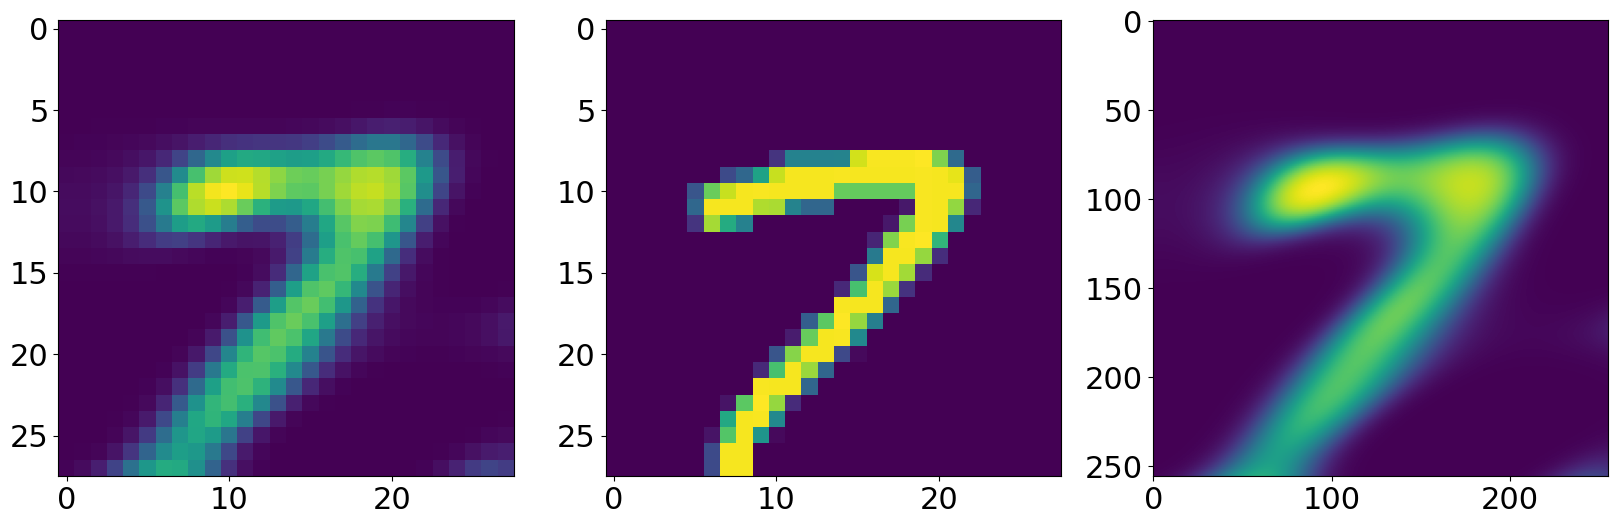

In [12]:
plt.subplot(1,3,1)
plt.imshow(pip.reshape((28,28)))
plt.subplot(1,3,2)
plt.imshow(pixels.reshape((28,28)))
plt.subplot(1,3,3)
plt.imshow(pipUp.reshape((256,256)))





## Sinc

In [15]:

inputs=layers.Input(shape=( 2,))

 # Define the multilayer perceptron
x1=layers.Dense(16, activation=tf.experimental.numpy.sinc)(inputs)
x2=layers.Dense(4, activation=tf.experimental.numpy.sinc)(x1)
x=layers.Dense(1, activation='sigmoid')(x2)

mlp=Model(inputs, x)

 # Compile the model
mlp.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

mlp.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_21 (Dense)            (None, 16)                48        
                                                                 
 dense_22 (Dense)            (None, 4)                 68        
                                                                 
 dense_23 (Dense)            (None, 1)                 5         
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


In [16]:
mlp.fit(train_dataset, epochs=1000)

Epoch 1/1000
25/25 [==============================] - 0s 884us/step - loss: 0.4584 - accuracy: 0.0051
Epoch 2/1000
25/25 [==============================] - 0s 785us/step - loss: 0.2721 - accuracy: 0.2793
Epoch 3/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.1833 - accuracy: 0.7895
Epoch 4/1000
25/25 [==============================] - 0s 845us/step - loss: 0.1619 - accuracy: 0.8240
Epoch 5/1000
25/25 [==============================] - 0s 883us/step - loss: 0.1554 - accuracy: 0.8240
Epoch 6/1000
25/25 [==============================] - 0s 924us/step - loss: 0.1512 - accuracy: 0.8240
Epoch 7/1000
25/25 [==============================] - 0s 901us/step - loss: 0.1475 - accuracy: 0.8240
Epoch 8/1000
25/25 [==============================] - 0s 828us/step - loss: 0.1439 - accuracy: 0.8240
Epoch 9/1000
25/25 [==============================] - 0s 827us/step - loss: 0.1405 - accuracy: 0.8240
Epoch 10/1000
25/25 [==============================] - 0s 965us/step - loss: 0.1373 

In [17]:
pap=mlp.predict(coords)
papUp=mlp.predict(upCoords)

2048/2048 [==============================] - 1s 440us/step


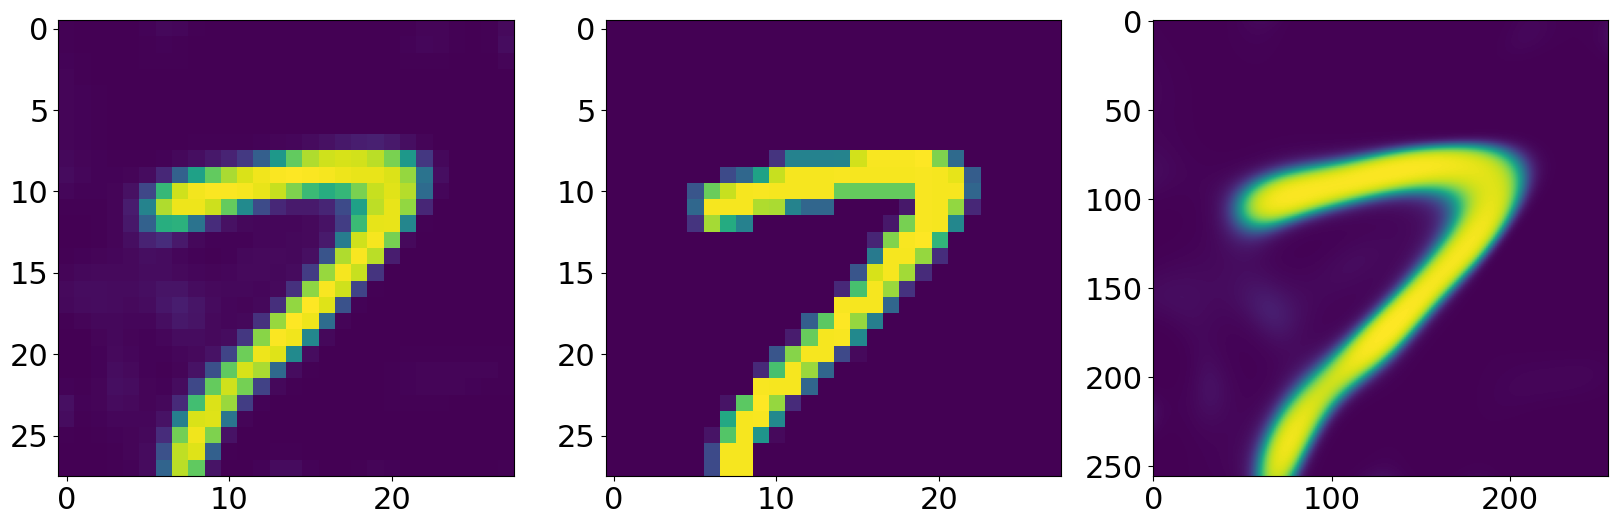

In [18]:
plt.subplot(1,3,1)
plt.imshow(pap.reshape((28,28)))
plt.subplot(1,3,2)
plt.imshow(pixels.reshape((28,28)))
plt.subplot(1,3,3)
plt.imshow(papUp.reshape((256,256)))

## Gelu

In [19]:
inputs=layers.Input(shape=( 2,))

 # Define the multilayer perceptron
x1=layers.Dense(16, activation='gelu')(inputs)
x2=layers.Dense(4, activation='gelu')(x1)
x=layers.Dense(1, activation='sigmoid')(x2)


mlp=Model(inputs, x)

 # Compile the model
mlp.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

mlp.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_24 (Dense)            (None, 16)                48        
                                                                 
 dense_25 (Dense)            (None, 4)                 68        
                                                                 
 dense_26 (Dense)            (None, 1)                 5         
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


In [20]:
mlp.fit(train_dataset, epochs=1000)

Epoch 1/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.2281 - accuracy: 0.4949
Epoch 2/1000
25/25 [==============================] - 0s 979us/step - loss: 0.2110 - accuracy: 0.7883
Epoch 3/1000
25/25 [==============================] - 0s 878us/step - loss: 0.1952 - accuracy: 0.8240
Epoch 4/1000
25/25 [==============================] - 0s 848us/step - loss: 0.1791 - accuracy: 0.8240
Epoch 5/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.1630 - accuracy: 0.8240
Epoch 6/1000
25/25 [==============================] - 0s 816us/step - loss: 0.1480 - accuracy: 0.8240
Epoch 7/1000
25/25 [==============================] - 0s 783us/step - loss: 0.1348 - accuracy: 0.8240
Epoch 8/1000
25/25 [==============================] - 0s 850us/step - loss: 0.1239 - accuracy: 0.8240
Epoch 9/1000
25/25 [==============================] - 0s 824us/step - loss: 0.1148 - accuracy: 0.8240
Epoch 10/1000
25/25 [==============================] - 0s 839us/step - loss: 0.1073 - 

In [21]:
pop=mlp.predict(coords)


25/25 [==============================] - 0s 492us/step


25/25 [==============================] - 0s 479us/step


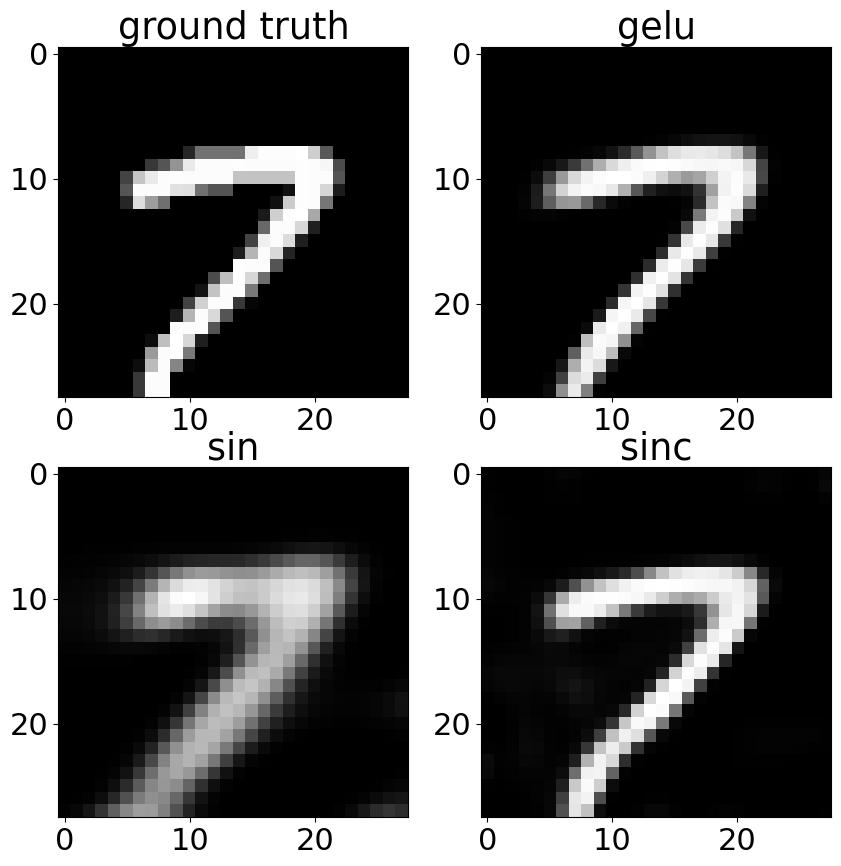

In [22]:
plt.figure(figsize=(10,10))
pop=mlp.predict(coords)
plt.subplot(2,2,1)
plt.imshow(pixels.reshape((28,28)), cmap='gray')
plt.title('ground truth')
plt.subplot(2,2,2)
plt.imshow(pop.reshape((28,28)), cmap='gray')
plt.title('gelu')
plt.subplot(2,2,3)
plt.imshow(pip.reshape((28,28)), cmap='gray')
plt.title('sin')
plt.subplot(2,2,4)
plt.imshow(pap.reshape((28,28)), cmap='gray')
plt.title('sinc')
plt.savefig('learnedNR.pdf')



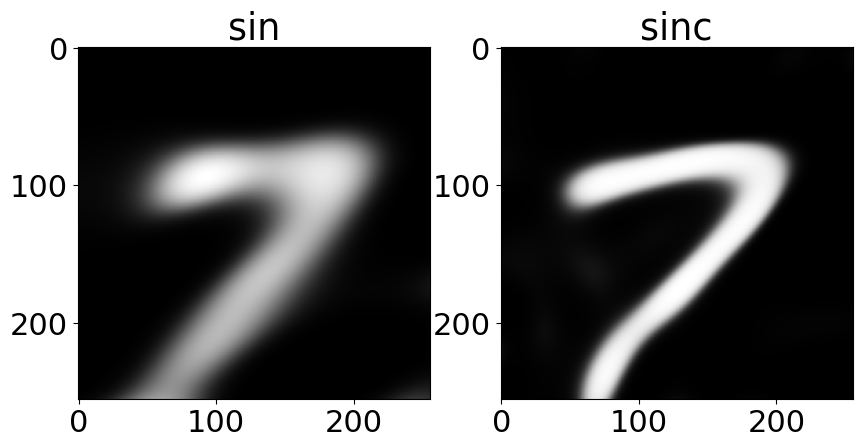

In [23]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(pipUp.reshape((256,256)), cmap='gray')
plt.title('sin')
plt.subplot(1,2,2)
plt.imshow(papUp.reshape((256,256)), cmap='gray')
plt.title('sinc')
plt.savefig('learnedNRup.pdf')